# Skills showed in this Notebook
The analysis covers data manipulation, computation and visualization, applying unsupervised learning algorithms, and hyperparameter tuning. The goal is to develop a time cohort analysis looking to find retention rates and try to cluster clients and analyze the characteristics of each group using an RFM analysis. 

This analysis is based in Python  
✅ Data manipulation : Numpy and Pandas  
✅ Data Visualization : Seaborn and Matplotlib  
✅ Unsupervised learning Techniques : Sklearn

# E-Commerce Data
This dataset consists of orders made in different countries from December 2010 to December 2011. The company is a UK-based online retailer that mainly sells unique all-occasion gifts, with many of its customers being wholesalers.

[Source of dataset](https://archive.ics.uci.edu/ml/datasets/online+retail#).

**Citation:** Daqing Chen, Sai Liang Sain, and Kun Guo, Data mining for the online retail industry: A case study of RFM model-based customer segmentation using data mining, Journal of Database Marketing and Customer Strategy Management, Vol. 19, No. 3, pp. 197-208, 2012 (Published online before print: 27 August 2012. doi: 10.1057/dbm.2012.17).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

In [3]:
internet = pd.read_csv('online_retail.csv') 
internet

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/10 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/10 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/10 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/10 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/10 8:26,3.39,17850.0,United Kingdom
...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,12/9/11 12:50,0.85,12680.0,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,12/9/11 12:50,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,12/9/11 12:50,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,12/9/11 12:50,4.15,12680.0,France


## Data preprocessing 
I do some data preprocessing in order to assign each column the correct kind of data type. Also I do a litle of missing handling to let the data ready for a time cohort analysis

In [4]:
internet['StockCode'] = internet.StockCode.astype('category')
internet['CustomerID']= internet.CustomerID.astype('category')
internet['InvoiceDate'] = pd.to_datetime(internet.InvoiceDate , format = '%m/%d/%y %H:%M')
internet['Country'] = internet.Country.astype('category')
internet['InvoiceNo'] = internet.InvoiceNo.astype('category')
internet['rev_x_item'] = internet.UnitPrice * internet.Quantity
internet.describe().T

,count,mean,std,min,25%,50%,75%,max
Quantity,541909.0,9.552250,218.081158,-80995.00,1.00,3.00,10.00,80995.0
UnitPrice,541909.0,4.611114,96.759853,-11062.06,1.25,2.08,4.13,38970.0
rev_x_item,541909.0,17.987795,378.810824,-168469.60,3.40,9.75,17.40,168469.6


There exist some negative UnitPrice rows that were for 'Adjust bad debt', both will be removed.   
Also, there exist some negative quantities but they are for return purchases; so they are canceling cells that had not been charged correctly.
Our analysis will focus only on the rows that have customerID because we need it to follow to make a time cohort analysis.

In [5]:
internet = internet.loc[internet.UnitPrice > 0]
internet.dropna(subset=['CustomerID'] , inplace = True)

## Time Cohort Analysis 
#### ¿Wich cohort has more retention rate?


In [6]:
def get_month(x): return dt.datetime(x.year, x.month , 1)
internet['InvoiceMonth'] = internet['InvoiceDate'].apply(get_month)
    

In [7]:
grouping = internet.groupby(['CustomerID'])['InvoiceMonth'] 
internet['CohortMonth'] = grouping.transform('min') # Getting the first Month of each client when they made the first purchase available in the Data Set.



In [8]:
#Making Cohort Anlysis Index.
def get_date_int(x) :   #Get the date in number of month
    year = x.dt.year 
    month = x.dt.month 
    total = year * 12 + month
    return total
total = get_date_int(internet['InvoiceMonth'])        #Getting the month where the purcharse were made. 
cohort_init = get_date_int(internet['CohortMonth'])   #Getting the month of the first purchase

internet['CohortIndex'] = total - cohort_init + 1    #Sum 1 to make it 0 indexing



In [9]:
#Get the number of buyer belonging to each cohor each month
grouping = internet.groupby(['CohortMonth', 'CohortIndex']) 
cohort_count = grouping['CustomerID'].apply(pd.Series.nunique).reset_index()
cohort_count = cohort_count.pivot_table(columns = 'CohortIndex', index = 'CohortMonth', values = 'CustomerID')
retention = cohort_count.divide(cohort_count.iloc[: , 0] , axis=0)
retention = retention.round(3) 


Text(0.5, 1.0, 'Retention Analysis')

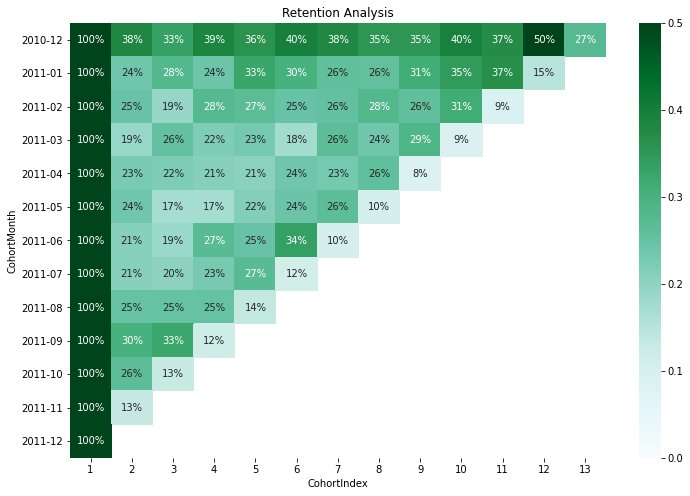

In [10]:
fig, ax = plt.subplots(figsize = (12,8))
ax = sns.heatmap(retention,
            vmin=0,
            vmax=0.5,
            cmap='BuGn',
            annot=True,
            fmt = '.0%',
            yticklabels=retention.index.strftime('%Y-%m'))
ax.set_title('Retention Analysis')


Retention rates show a big drop-off in the second month, however, then it starts to increase for all the cohorts. Higher retention rates are related to Christmas and New Year celebrations.  
The cohort of 2010-12 has the highest retention rates and shows a high peak one year before the first purchase probably related to the end year celebrations.

## RFM segmentation.

RFM segmentation is a marketing technique that allows the company to do a behavioral customer segmentation, classifying the customer taking into account the client's Recency(R), Frequency(F), and Monetary Value(M) of the spending.  
Recency is defined as how many days happen between the client's last purchase. Frequency is defined as how often the client purchase and is the yearly number of purchases done by a client. Finally, Monetary Value is the total money spent by a client.

In [11]:
#Developing Recency, Frquency and Monetary Value  features. 
last_day = internet.InvoiceDate.max()  #Last day in the DataSet. 

rfm = internet.groupby('CustomerID').agg({
    'InvoiceDate' : lambda x : (last_day - x.max()).days ,
    'InvoiceNo' : 'count',
    'rev_x_item' : 'sum'})

rfm.columns =  ['Recency' , 'Frequency' , 'MonetaryValue']

rfm.isna().sum()

Recency          1
Frequency        0
MonetaryValue    0
dtype: int64

### Data preprocessing
K-means make some assumptions:
1) The variables have the same distribution, especially they wouldn't be skewed.
2) The variables have the same variance
3) The variables have the same mean. 

For 1 the solution is to apply a natural logarithmic transformation, and for 2 and 3  the solution is to apply StandardScaler function that turns the mean and the variance of each variable to 0 and 1 respectively.

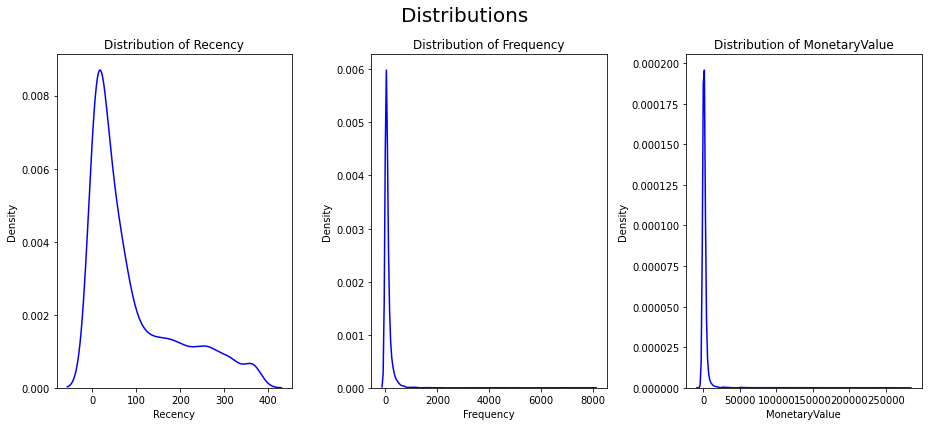

In [12]:
plt.figure(figsize = (13,6))
for i, var in enumerate(rfm.columns):
    plt.subplot(1, 3 , i+1); sns.kdeplot(x= rfm[var] , color = 'blue')
    plt.title(f'Distribution of {var}')
plt.suptitle('Distributions', fontsize = 20)
plt.tight_layout()

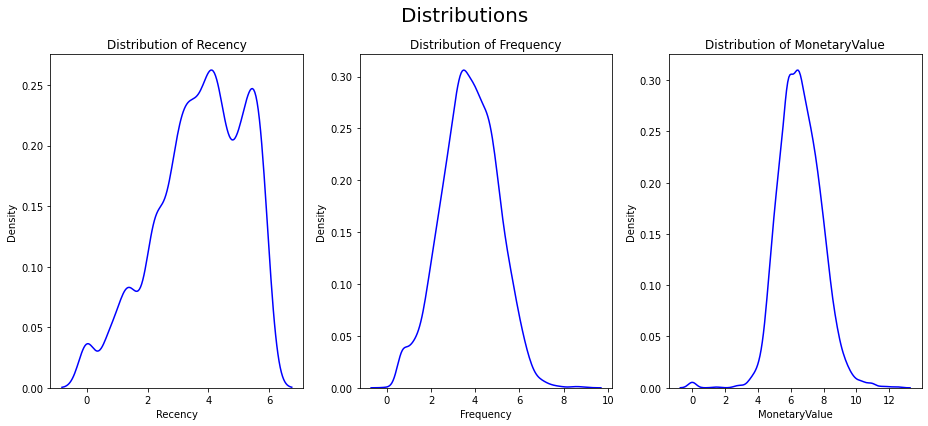

In [13]:
rfm_l = np.log(rfm+1)
plt.figure(figsize = (13,6))
for i, var in enumerate(rfm_l.columns):
    plt.subplot(1, 3 , i+1); sns.kdeplot(x= rfm_l[var] ,color = 'blue')
    plt.title(f'Distribution of {var}')
plt.suptitle('Distributions', fontsize = 20)
plt.tight_layout()

Although Recency distribution doesn't have a too-bell shape,  Monetary Value and Frequency distributions do it has. 

In [14]:
scaler = StandardScaler()
rfm_l_e = scaler.fit_transform(rfm_l)

rfm_data_n = pd.DataFrame(rfm_l_e , columns = rfm.columns , index = rfm.index)
rfm_data_n.dropna(inplace = True)
rfm_data_n.describe().round(2)

,Recency,Frequency,MonetaryValue
count,4330.00,4330.00,4330.00
mean,-0.01,0.02,0.00
std,1.00,0.98,1.00
min,-2.55,-2.41,-5.05
25%,-0.61,-0.63,-0.65
50%,0.12,0.02,-0.05
75%,0.82,0.71,0.65
max,1.50,4.15,4.62


### Optimal Clusters numbers 

One of the problems of KMeans clustering method is to address the question about how many clusters exist?. Too many clusters should cause overfitting but too little should cause biased conclusions. To answer this question one should do an elbow analysis, in which you should choose the number of clusters that gives a high reduction of the inertia ( inertia is a measure of how coherent is every cluster internally).

Text(0.5, 1.0, 'Elbow method')

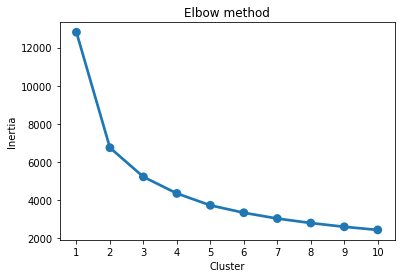

In [15]:
%%capture --no-display
SSE = {}

for k in range(1,11):
    kmean = KMeans(n_clusters = k)
    kmean.fit(rfm_data_n)
    SSE[k] = kmean.inertia_
    
sns.pointplot(x= list(SSE.keys()) , y=list(SSE.values()))
plt.ylabel('Inertia')
plt.xlabel('Cluster')
plt.title('Elbow method')

It seems possible to use 3 and also 4 clusters. I Will pick 3 just to keep the analysis simpler.

In [16]:
%%capture
#Model 
model = KMeans(n_clusters = 3 , random_state = 1)
model.fit(rfm_data_n) 



### Snake Plot y Cluster Analysis

In [17]:
rfm = rfm.loc[rfm_data_n.index].assign(Cluster = model.labels_)
rfm_data_n = rfm_data_n.assign(Cluster = model.labels_)

In [18]:
Summary = rfm.groupby('Cluster').agg(
    {'Recency' : ['mean' , 'std'],
    'Frequency' : ['mean' , 'std'],
    'MonetaryValue' : ['mean' , 'std', 'count']}).round(2)

rfm_data_n.reset_index(inplace = True)
rfm_data_n_S = pd.melt(rfm_data_n, 
                       id_vars = ['CustomerID', 'Cluster'],
                       value_vars = ['Recency' , 'Frequency' , 'MonetaryValue'],
                      var_name = 'Attribute',
                      value_name = 'Value')

Cluster                    0        1         2
Recency       mean    167.12    65.92     11.05
              std     109.56    65.51     12.74
Frequency     mean     15.57    67.47    267.84
              std      12.45    48.56    445.07
MonetaryValue mean    281.72  1090.98   6081.57
              std     234.89  1047.59  16744.89
              count  1528.00  1835.00    967.00

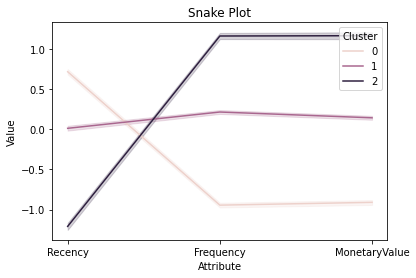

In [19]:
display(Summary.T)
plt.title('Snake Plot')
sns.lineplot(x='Attribute' ,
             y='Value',
             hue = 'Cluster',
            data = rfm_data_n_S)
plt.show()

Cluster 2 is the most important for the business and is compound by 967 members. They have the lower Recency mean (11 days has passed since the last purchase), the highest Frequency( On average they buy 267 times the last year), and Monetary Value (On average they spend 6081 sterlings pounds). They could be called Gold clients.  
Cluster 1 is compound by 1835 members. They have the regular Recency mean (66 days has passed since the last purchase), Frequency( On average they buy 67 times the last year), and Monetary Value (On average they spend 1090 sterlings pounds). They could be called Silver clients.  
Finally, Cluster 0 could be called Bronze clients, they have the highest Recency, and the lower Frequency and Monetary Value.

### Feature relative importance

Relative feature importance analysis shows how is every cluster mean related to the overall population. 

In [36]:
mean_c = rfm.groupby('Cluster').mean()
mean = rfm.mean()
relative_importance = mean_c / mean  - 1
relative_importance.drop(columns = 'Cluster' , inplace =True)
relative_importance

,Frequency,MonetaryValue,Recency
Cluster,,,
0,-0.834174,-0.853265,0.869774
1,-0.281529,-0.431759,-0.262443
2,1.852351,2.167599,-0.876352


<AxesSubplot:title={'center':'Relative Feature Importance'}, ylabel='Cluster'>

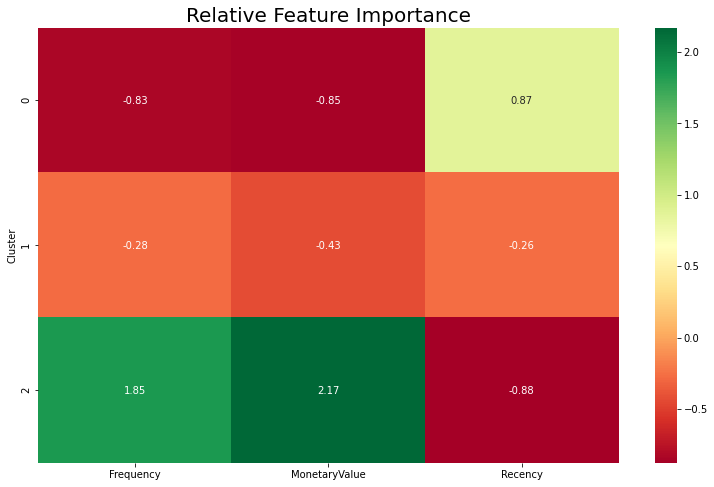

In [43]:
plt.figure(figsize = (13,8))
plt.title('Relative Feature Importance', fontsize = 20)
sns.heatmap(relative_importance,
            fmt = '.2f',
            cmap = 'RdYlGn',
            annot = True)

Again is possible to see that the Golden clients (Cluster 2) have the most Frequency, Monetary Value, and the lower Recency. In contrast, Cluster 0 has lower Frequency, Monetary Value, and longest Recency.